In [136]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import cross_val_predict,  cross_val_score 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import seaborn as sns
import datetime as dt
import time

# Cleaning Data

## Clearing entries, encoding names, converting values

In [137]:
df=pd.read_csv('shot_logs.csv')

In [138]:
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [139]:
def fix_names(x):
    if x =="alancrabbe":
        return "allencrabbe"
    elif x=="benourdih":
        return "benoudrih"
    elif x=="danilogallinai":
        return "danilogallinari"
    elif x=="dirknowtizski":
        return "dirknowitzki"
    elif x=="dwaynewade":
        return "dwyanewade"
    elif x=="jimmerdredette":
        return "jimmerfredette"
    elif x=="joningles":
        return "joeingles"
    elif x=="josejuanbarea":
        return "jjbarea"
    elif x=="kentaviouscaldwell-pope":
        return "kentaviouscaldwellpope"
    elif x=="michaelcarter-williams":
        return "michaelcarterwilliams"
    elif x=="mntaellis":
        return "montaellis"
    elif x=="nerlesnoel":
        return "nerlensnoel"
    elif x=="steveadams":
        return "stevenadams"
    elif x=="timehardawayjr":
        return "timhardaway"
    else:
        return x


In [140]:
new_df=df.drop(columns=['FGM','player_id','CLOSEST_DEFENDER_PLAYER_ID','GAME_ID','FINAL_MARGIN','SHOT_NUMBER'])
new_df=new_df.rename(columns={"LOCATION": "Home/Away", "W": "Win/Loss", "player_name": "PLAYER_NAME"})

In [141]:
def clean_names(x):
    name=""
    for ind,i in enumerate(x):
        if i==',':
            break
    for s in range (ind+1,len(x)):
        name+=x[s]
    name+=' '
    for t in range(0,ind):
        name+=x[t]
    return str.lower(name).replace(" ","")
def clean_names2(x):
    return x.replace(" ","")

In [142]:
new_df['CLOSEST_DEFENDER']=new_df['CLOSEST_DEFENDER'].apply(clean_names)
new_df['PLAYER_NAME']=new_df['PLAYER_NAME'].apply(clean_names2)
new_df['CLOSEST_DEFENDER']=new_df['CLOSEST_DEFENDER'].apply(fix_names)
new_df['PLAYER_NAME']=new_df['PLAYER_NAME'].apply(fix_names)

In [143]:
def bi_shot_result(x):
    if x=='missed':
        return 0
    else:
        return 1
def bi_numb(x):
    if x=='A'or x=='L':
        return 0
    elif x=='H' or x=='W':
        return 1
    else:
        return x
def clean_clock(x):
    return float(x.replace(":" , "."))
new_df['GAME_CLOCK']=new_df['GAME_CLOCK'].apply(clean_clock)
new_df['SHOT_RESULT']=new_df['SHOT_RESULT'].apply(bi_shot_result)
new_df['Home/Away']=new_df['Home/Away'].apply(bi_numb)
new_df['Win/Loss']=new_df['Win/Loss'].apply(bi_numb)
new_df=new_df.drop(columns=['PTS','PTS_TYPE','DRIBBLES','TOUCH_TIME','MATCHUP'])
new_df=new_df.dropna()
new_df = new_df.drop(columns=['SHOT_CLOCK','Win/Loss'])

In [144]:
all_players=[]
for i in new_df['PLAYER_NAME']:
    if i not in all_players:
        all_players.append(i)
for j in new_df['CLOSEST_DEFENDER']:
    if j not in all_players:
        all_players.append(j)
        
label_enc = LabelEncoder()
label_enc.fit(all_players)
new_df['CLOSEST_DEFENDER']=label_enc.transform(new_df['CLOSEST_DEFENDER'])

In [145]:
new_df.head()

,Home/Away,PERIOD,GAME_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER,CLOSE_DEF_DIST,PLAYER_NAME
0,0,1,1.09,7.7,1,5,1.3,brianroberts
1,0,1,0.14,28.2,0,47,6.1,brianroberts
3,0,2,11.47,17.2,0,315,3.4,brianroberts
4,0,2,10.34,3.7,0,435,1.1,brianroberts
5,0,2,8.15,18.4,0,111,2.6,brianroberts


## Suffle the data to prepare for splitting

In [13]:
new_df = new_df.sample(frac = 1) # suffle the data
new_df

,Home/Away,PERIOD,GAME_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER,CLOSE_DEF_DIST,PLAYER_NAME
102786,1,4,11.15,25.6,0,473,7.3,reggiejackson
61175,1,3,1.29,12.5,1,287,3.8,timduncan
126218,0,2,5.59,22.6,0,251,6.1,deronwilliams
87702,1,4,1.04,26.0,0,98,4.3,kentaviouscaldwellpope
40958,1,4,4.23,16.4,0,156,5.2,evanfournier
...,...,...,...,...,...,...,...,...
52030,0,4,4.54,2.3,0,442,3.0,davidwest
18276,1,4,4.51,18.0,0,77,3.6,alhorford
41220,0,3,10.16,23.3,0,264,5.2,evanfournier
117601,0,1,10.14,18.0,0,376,2.1,lamarcusaldridge


## Note on the data shuffling

---


For this notebook the dataframe is shuffled to have a random split over  the train/validation/test sets. Every time the notebook is run it generates a different splitted dataset to be evaluated so the results will be a bit different. Therefore the dataset evaluated 1st was saved and is now uploaded to be the new_df and all cells shall be run using this cleaned and shuffled dataset. (All the results will be refering to this one data set)

In [14]:
Cleaned_data = pd.read_csv('Cleaned_data.csv').drop(columns =['Unnamed: 0'])
Cleaned_data.head()

,Home/Away,PERIOD,GAME_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER,CLOSE_DEF_DIST,PLAYER_NAME
0,1,4,8.39,24.2,0,452,4.7,dwyanewade
1,0,3,3.14,24.5,1,187,4.9,cjmccollum
2,1,3,6.17,2.7,0,241,3.8,lamarcusaldridge
3,1,2,10.45,8.8,0,281,1.2,shabazzmuhammad
4,0,4,4.27,3.0,1,48,2.0,ryananderson


## Normalizing and splitting data

In [15]:
# normalization function
scaler=MinMaxScaler()
def normalization(df):
  scaler.fit(Cleaned_data.drop(columns= ['PLAYER_NAME','SHOT_RESULT']))
  data = scaler.transform(df)
  data = pd.DataFrame(data)
  c = (Cleaned_data.drop(columns= ['PLAYER_NAME','SHOT_RESULT'])).columns
  columns = []
  for i in range(6):
    columns.append(c[i])
  data.columns = columns
  return data

new_df = normalization(Cleaned_data.drop(columns= ['PLAYER_NAME','SHOT_RESULT']))
new_df['SHOT_RESULT'] =  np.array(Cleaned_data['SHOT_RESULT'])
new_df['PLAYER_NAME'] =  np.array(Cleaned_data['PLAYER_NAME'])

new_df

,Home/Away,PERIOD,GAME_CLOCK,SHOT_DIST,CLOSEST_DEFENDER,CLOSE_DEF_DIST,SHOT_RESULT,PLAYER_NAME
0,1.0,0.500000,0.698916,0.556322,0.943633,0.088346,0,dwyanewade
1,0.0,0.333333,0.261051,0.563218,0.390397,0.092105,1,cjmccollum
2,1.0,0.333333,0.513761,0.062069,0.503132,0.071429,0,lamarcusaldridge
3,1.0,0.166667,0.870726,0.202299,0.586639,0.022556,0,shabazzmuhammad
4,0.0,0.500000,0.355296,0.068966,0.100209,0.037594,1,ryananderson
...,...,...,...,...,...,...,...,...
122497,1.0,0.333333,0.087573,0.521839,0.066806,0.095865,0,robertcovington
122498,1.0,0.000000,0.025021,0.551724,0.576200,0.077068,0,trevorariza
122499,0.0,0.166667,0.928274,0.521839,0.935282,0.065789,0,ojmayo
122500,1.0,0.000000,0.594662,0.066667,0.912317,0.048872,1,ericbledsoe


In [16]:
# splitting data
global x_train, x_test, x_val, y_train, y_test , y_val, players 

L = len(new_df)
train = int(L*0.8)
test = train + int(L*0.1)
val = test + int(L*0.1) + 1

x_train = new_df[0:train].drop(columns = 'SHOT_RESULT')
y_train = new_df[0:train].drop(columns = ['Home/Away',	'PERIOD',	'GAME_CLOCK',	'SHOT_DIST','CLOSEST_DEFENDER',	'CLOSE_DEF_DIST'])

x_test = new_df[train:test].drop(columns = 'SHOT_RESULT')
y_test = new_df[train:test].drop(columns = ['Home/Away',	'PERIOD',	'GAME_CLOCK',	'SHOT_DIST','CLOSEST_DEFENDER',	'CLOSE_DEF_DIST'])

x_val = new_df[test:val].drop(columns = 'SHOT_RESULT')
y_val = new_df[test:val].drop(columns = ['Home/Away',	'PERIOD',	'GAME_CLOCK',	'SHOT_DIST','CLOSEST_DEFENDER',	'CLOSE_DEF_DIST'])

x_train = x_train.sort_values(by = 'PLAYER_NAME') # player names in alphabetical order
x_test = x_test.sort_values(by = 'PLAYER_NAME') 
x_val = x_val.sort_values(by = 'PLAYER_NAME') 

y_train = (y_train.sort_values(by = 'PLAYER_NAME'))['SHOT_RESULT'] # only have Shots Result
y_test = (y_test.sort_values(by = 'PLAYER_NAME'))['SHOT_RESULT']
y_val = (y_val.sort_values(by = 'PLAYER_NAME'))['SHOT_RESULT'] 

players = np.unique(new_df['PLAYER_NAME'])

print(len(players),
      len(np.unique(x_test['PLAYER_NAME'])), # check if splits didn't lose any player
      len(np.unique(x_val['PLAYER_NAME'])),
      len(np.unique(x_train['PLAYER_NAME'])))

281 281 281 281


# Modeling data

## Logistic Regression model

### Notes on the model


---


We can easily check that the C parameter does change the accuracy. The value at which the model is best tuned is may vary from player to player so we shall test the function for a given set of features [1,1,7.56,3.6,210,13.7] and see how much time it takes for the function to run with 20 different values for the paremeter C (from 0.1 to 10) for the 5 players with most data points.

We get a not so bad accuracy score in average (~62%) in just 10 seconds which tells us that the logistic regression fits the data somewhat good. A more complex approach should be tried.

In [23]:
def LR(x,y,C): # C value won't affect results
  return LogisticRegression(max_iter=1000, C = C).fit(x, y)


def Logistic_regression(features,player, step):

  if player not in players:
        return('Player not available')

  player_indexes_train, = np.where(x_train['PLAYER_NAME'] == player)
  player_indexes_test, = np.where(x_test['PLAYER_NAME'] == player)
  player_indexes_val, = np.where(x_val['PLAYER_NAME'] == player)


  LR_train_x = (x_train[:][player_indexes_train[0]:player_indexes_train[-1]]).drop(columns=['PLAYER_NAME'])
  LR_train_y = y_train[:][player_indexes_train[0]:player_indexes_train[-1]]

  LR_test_x = (x_test[:][player_indexes_test[0]:player_indexes_test[-1]]).drop(columns=['PLAYER_NAME'])
  LR_test_y = y_test[:][player_indexes_test[0]:player_indexes_test[-1]]
   
  LR_val_x = (x_val[:][player_indexes_val[0]:player_indexes_val[-1]]).drop(columns=['PLAYER_NAME'])
  LR_val_y = y_val[:][player_indexes_val[0]:player_indexes_val[-1]]
  
  

  features = {'Home/Away':[features[0]], 'PERIOD':[features[1]], 'GAME_CLOCK':[features[2]],
                'SHOT_DIST':[features[3]],'CLOSEST_DEFENDER':[features[4]], 'CLOSE_DEF_DIST':[features[5]]}

  features_df = normalization(pd.DataFrame(features))

  # Tuning parameter C
  Cs = np.arange(0.1, 10, step, dtype = float)
  means = []
  accs = []

  for i,C in enumerate(Cs):
    scores = cross_val_score(LR(LR_train_x, LR_train_y, C), LR_val_x, LR_val_y, cv=10)
    means.append(np.mean(scores))
    validated_LR = LR(LR_train_x, LR_train_y, C)
    y_predict = validated_LR.predict(LR_test_x)
    accs.append(np.round(accuracy_score(y_predict, LR_test_y ),3)*100)
  
  max_index = np.where(means == max(means))[0][0]
  best_C = Cs[max_index]

  validated_LR = LR(LR_train_x, LR_train_y, best_C)
  #y_predict = validated_LR.predict(LR_test_x)
  #acc = np.round(accuracy_score(y_predict, LR_test_y ),3)*100
  
  print('Best C parameter is equal to {}'.format(best_C))
  return validated_LR.predict_proba(features_df)[0][1] * 100 , accs # will return the probability of the player scoring and the accuracy of the model

#trying  function with lebron james
Logistic_regression(np.array([1,1,7.56,3.6,210,13.7]),'lebronjames',9) # steps 9  will result in 1 iterations --> 1 values of C from 0.1 to 10

Best C parameter is equal to 9.1


(83.6059618055508, [67.9, 66.7])

### Testing accuracies for the 5 players with the most entries in the data-set

In [36]:
features = np.array([1,1,7.56,3.6,210,13.7])

biggest = []
player_i = []

for i in (np.unique(new_df['PLAYER_NAME'])):
    biggest.append(len(np.where(new_df['PLAYER_NAME']==i)[0]))
    player_i.append(i)

biggest = np.array(biggest)
biggest_5 = np.sort(biggest)[-5:]
biggest_5player = []
for i in biggest_5:
    j, = (np.where(biggest == i )[0])
    biggest_5player.append(player_i[j])

start = time.time()
step = 0.5 # number of Cs will be 10/step = 20

LR_accs = []
for player in biggest_5player:
    prob, acc = Logistic_regression(np.array([1,1,7.56,3.6,210,13.7]),player,step)
    LR_accs.append(acc)
    print('The probability of {} scoring, with an accuracy of {:.1f}%, is {:.2f}%'.format(player,max(acc),prob))
    print("")

end = time.time()
print('Time elapsed to get best accuracy result for {} diffent C values, and all 5 players was of {:.2f} min.'.format(10/step, (end-start)/60 ))

Best C parameter is equal to 1.6
The probability of lebronjames scoring, with an accuracy of 67.9%, is 72.19%

Best C parameter is equal to 0.1
The probability of klaythompson scoring, with an accuracy of 62.1%, is 55.32%

Best C parameter is equal to 0.1
The probability of montaellis scoring, with an accuracy of 61.5%, is 47.64%

Best C parameter is equal to 4.6
The probability of jamesharden scoring, with an accuracy of 56.5%, is 69.70%

Best C parameter is equal to 2.6
The probability of lamarcusaldridge scoring, with an accuracy of 61.3%, is 72.65%

Time elapsed to get best accuracy result for 20.0 diffent C values, and all 5 players was of 0.17 min.


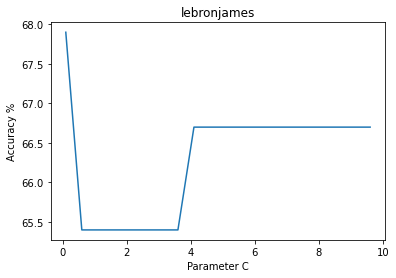

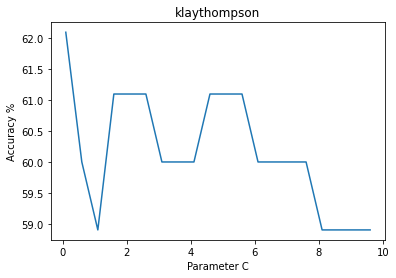

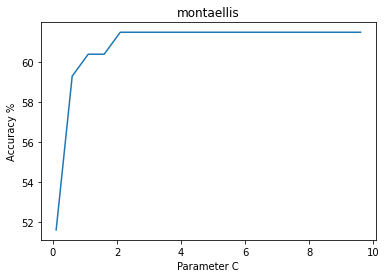

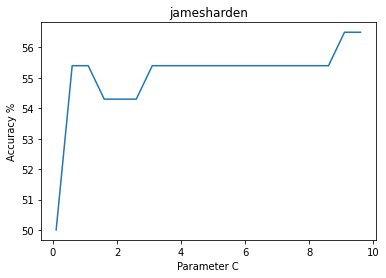

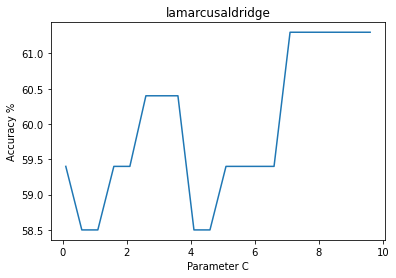

In [37]:
Cs = np.arange(0.1, 10, step, dtype = float)
for i,player in enumerate(biggest_5player):
    plt.plot(Cs,LR_accs[i])
    plt.xlabel('Parameter C')
    plt.ylabel('Accuracy %')
    plt.title(player)
    plt.show()

## SVM Model

### Poly Kernel

##### Notes on the model

---


The SVM model ,with a poly kernel, is here evaluated for different parameters, other parameters (like higher degree) may increase the accuracy but not so much that it compensates the time it takes to run. Once again best parameter values will be different for different player so the model has to be validated for each player. The way to get the most accurate prediction is what makes the algorithm slower.

Again we can easily check that the C and d parameters do change the accuracy. To see how the function works we shall test it for the same set of features as before, [1,1,7.56,3.6,210,13.7], and see how much time it takes for the function to run with combinations of 20 different values of C and 3 different values of D.

The average accuracy for 5 players doesn't improve compared to the LR model and remains around ~61% but the algorithm takes twice as much time to find the best parameters, worth noting it is validating many more paramenters and runing the training 60 times. We shall try a new approach and use another of the most popular kernels for SVM models which is the RBF and see how/if we get better results.

In [129]:

def SVM_fit(C,d,x,y):
        return svm.SVC(kernel='poly', degree=d, C=C,coef0 = 0.1, probability = True).fit(x, y)

def SVM(features, player):

    if player not in players:
        return('Player not available')

    features = {'Home/Away':[features[0]], 'PERIOD':[features[1]], 'GAME_CLOCK':[features[2]],
                'SHOT_DIST':[features[3]],'CLOSEST_DEFENDER':[features[4]], 'CLOSE_DEF_DIST':[features[5]]}

    features_df = normalization(pd.DataFrame(features))
        
    
    player_indexes_train, = np.where(x_train['PLAYER_NAME'] == player)
    player_indexes_test, = np.where(x_test['PLAYER_NAME'] == player)
    player_indexes_val, = np.where(x_val['PLAYER_NAME'] == player)


    SVM_train_x = (x_train[:][player_indexes_train[0]:player_indexes_train[-1]]).drop(columns=['PLAYER_NAME'])
    SVM_train_y = y_train[:][player_indexes_train[0]:player_indexes_train[-1]]

    SVM_test_x = (x_test[:][player_indexes_test[0]:player_indexes_test[-1]]).drop(columns=['PLAYER_NAME'])
    SVM_test_y = y_test[:][player_indexes_test[0]:player_indexes_test[-1]]

        
    SVM_val_x = (x_val[:][player_indexes_val[0]:player_indexes_val[-1]]).drop(columns=['PLAYER_NAME'])
    SVM_val_y = y_val[:][player_indexes_val[0]:player_indexes_val[-1]]
    
  
    # validation
    Cs = np.arange(0.1, 10, 0.5, dtype = float)
    ds = [1,2,3] 
    accs = np.zeros([len(ds),len(Cs)])
    means = np.zeros([len(ds),len(Cs)])
    for i,d in enumerate(ds):
        for j,c in enumerate(Cs):
            scores = cross_val_score(SVM_fit(c,d,SVM_train_x,SVM_train_y), SVM_val_x, SVM_val_y, cv=10)
            means[i,j] = np.mean(scores)
            poly_fit  = SVM_fit(c,d,SVM_train_x, SVM_train_y)
            y_predict = poly_fit.predict(SVM_test_x)
            accs[i,j] = (np.round(accuracy_score(y_predict, SVM_test_y ),3)*100)
            
    best_d_index = np.where(means == means.max())[0]
    best_c_index = np.where(means == means.max())[1]
    best_d = ds[best_d_index[0]]
    best_c =Cs[best_c_index[0]]
    print("The model is optimized with parameters d =",best_d,"e C =", best_c) # usually d = 1, C = 8

    poly_fit  = SVM_fit(best_c,best_d,SVM_train_x, SVM_train_y)
    y_predict = poly_fit.predict(SVM_test_x)
    acc = np.round(accuracy_score(y_predict, SVM_test_y ),3)*100

    
    
    return poly_fit.predict_proba(features_df)[0][1] * 100, acc, accs


#SVM(np.array([1,1,7.56,3.6,210,13.7]),'lebronjames') # testing function 

#### Testing accuracies for the 5 players with the most entries in the data-set

In [135]:
start = time.time()
SVM_accs = []
for player in biggest_5player:
    prob, acc,accs = SVM(features,player)
    SVM_accs.append(accs)
    print('The probability of {} scoring, with an accuracy of {:.1f}%, is {:.1f}%'.format(player,acc,prob))
    print("")

end = time.time()
print('Time elapsed to get best accuracy result for the parameters combinations of 20 different values of C and 3 different values of D and all 5 players was of {:.2f} min.'.format((end-start)/60))

The model is optimized with parameters d = 2 e C = 2.1
The probability of lebronjames scoring, with an accuracy of 66.7%, is 69.2%

The model is optimized with parameters d = 3 e C = 0.1
The probability of klaythompson scoring, with an accuracy of 61.1%, is 55.8%

The model is optimized with parameters d = 2 e C = 2.1
The probability of montaellis scoring, with an accuracy of 64.8%, is 60.1%

The model is optimized with parameters d = 1 e C = 1.6
The probability of jamesharden scoring, with an accuracy of 51.1%, is 58.8%

The model is optimized with parameters d = 3 e C = 8.1
The probability of lamarcusaldridge scoring, with an accuracy of 60.4%, is 71.8%

Time elapsed to get best accuracy result for the parameters combinations of 20 different values of C and 3 different values of D and all 5 players was of 2.03 min.


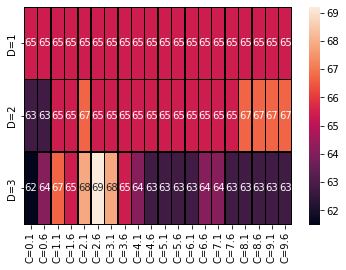

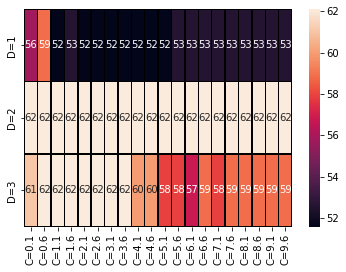

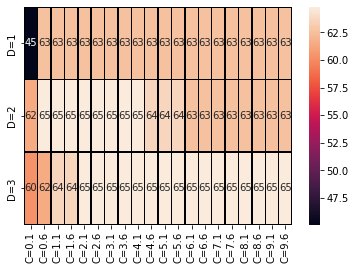

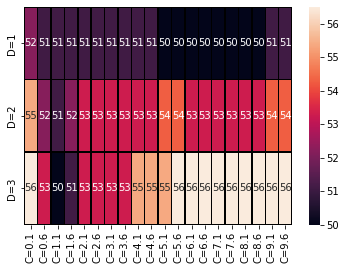

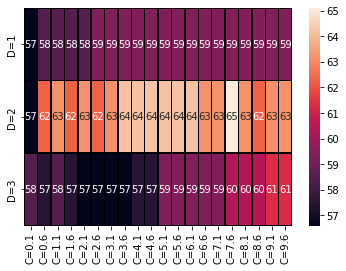

In [131]:
Cs = np.arange(0.1, 10, 0.5, dtype = float)
ds = [1,2,3]
grid = []
for i,player in enumerate(biggest_5player):
  plot = pd.DataFrame(SVM_accs[i], columns=Cs)
  plot = plot.add_prefix('C=')
  plot.index = plot.index + 1
  plot = plot.rename(index={1: 'D=1',2:'D=2',3:'D=3'})
  sns.heatmap(plot,annot = True,linecolor = 'k',cbar = True,linewidths = .5)
  plt.show()
  

### SVM with RBF kernel

In [132]:
def SVM_RBF_fit(C,g,x,y):
        return svm.SVC(kernel='rbf', gamma = g, C=C, probability = True).fit(x, y)

def SVM_RBF(features, player):

    if player not in players:
        return('Player not available')

    features = {'Home/Away':[features[0]], 'PERIOD':[features[1]], 'GAME_CLOCK':[features[2]],
                'SHOT_DIST':[features[3]],'CLOSEST_DEFENDER':[features[4]], 'CLOSE_DEF_DIST':[features[5]]}
    features_df = normalization(pd.DataFrame(features))
        
    
    player_indexes_train, = np.where(x_train['PLAYER_NAME'] == player)
    player_indexes_test, = np.where(x_test['PLAYER_NAME'] == player)
    player_indexes_val, = np.where(x_val['PLAYER_NAME'] == player)


    SVM_train_x = (x_train[:][player_indexes_train[0]:player_indexes_train[-1]]).drop(columns=['PLAYER_NAME'])
    SVM_train_y = y_train[:][player_indexes_train[0]:player_indexes_train[-1]]

    SVM_test_x = (x_test[:][player_indexes_test[0]:player_indexes_test[-1]]).drop(columns=['PLAYER_NAME'])
    SVM_test_y = y_test[:][player_indexes_test[0]:player_indexes_test[-1]]

        
    SVM_val_x = (x_val[:][player_indexes_val[0]:player_indexes_val[-1]]).drop(columns=['PLAYER_NAME'])
    SVM_val_y = y_val[:][player_indexes_val[0]:player_indexes_val[-1]]
    
  
    # validation
    Cs = [1/2,2,8,10,12]
    gs = [0.001,0.01,0.1,1,5,10]
    means = np.zeros([len(gs),len(Cs)])
    for i,g in enumerate(gs):
        for j,c in enumerate(Cs):
            scores = cross_val_score(SVM_RBF_fit(c,g,SVM_train_x,SVM_train_y), SVM_val_x, SVM_val_y, cv=10)
            means[i,j] = np.mean(scores)
            
    best_g_index = np.where(means == means.max())[0]
    best_c_index = np.where(means == means.max())[1]
    best_g = gs[best_g_index[0]]
    best_c =Cs[best_c_index[0]]
    print("The model is optimized with parameters gamma =",best_g,"e C =", best_c)

    poly_fit  = SVM_fit(4,best_g,SVM_train_x, SVM_train_y)
    y_predict = poly_fit.predict(SVM_test_x)
    acc = np.round(accuracy_score(y_predict, SVM_test_y ),3)*100
    #print('With an accuracy of:',acc,'%')
    
    
    return poly_fit.predict_proba(features_df)[0][1] * 100, acc

test = SVM_RBF(np.array([1,1,7.56,3.6,210,13.7]),'lebronjames')
print('We got an accuracy of {}% for the player lebronjames'.format(test[1]))

The model is optimized with parameters gamma = 0.1 e C = 8
We got an accuracy of 50.0% for the player lebronjames


As this model only gets an accuracy of 50% we shall not explore it further as it is far worse than those used before.

## FFNN Model

### Notes on the model


---


Here we develop a function able to create a double layer neural network which can have the number of nodes tuned. For that purpose several numbers of nodes will be tried from 1 to 23 nodes in steps of 3, this makes the function run 49 times every time it is called. This is the reason why it takes so long to run.

Even though the wait is long, the results are far better, with an average accuracy of ~70%. One must be aware that issues arise when using the same number of nodes for different users as they have different ways to better be trained. 

Below we train the model for the same 5 players as before and see what is the best combination of nodes for each player, we can check that it changes for every player. Also the number of layers should be changed, but for the project purpose this is going too far from the goal of having lowcalculation speed.

We can also check the trainings convergence, from the problems stated before, fixing them might fix the convergence for each player.

**Note**: # epochs, batch_size and number of layers were selected based on a trial by error using the lebronjames player only.

In [ ]:
players = np.unique(new_df['PLAYER_NAME'])

def model_fit(nodes1,nodes2):
    model = Sequential()
    model.add(Dense(nodes1, input_dim=6, activation='relu'))
    model.add(Dense(nodes2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def FFNN(features, player):

    
    if player not in players:
        return('Player not available')
    
    features = {'Home/Away':[features[0]], 'PERIOD':[features[1]], 'GAME_CLOCK':[features[2]],
                'SHOT_DIST':[features[3]],'CLOSEST_DEFENDER':[features[4]], 'CLOSE_DEF_DIST':[features[5]]}
    
    features_df = normalization(pd.DataFrame(features))
    
    player_indexes_train, = np.where(x_train['PLAYER_NAME'] == player)
    player_indexes_test, = np.where(x_test['PLAYER_NAME'] == player)
    player_indexes_val, = np.where(x_val['PLAYER_NAME'] == player)


    FFNN_train_x = (x_train[:][player_indexes_train[0]:player_indexes_train[-1]]).drop(columns=['PLAYER_NAME'])
    FFNN_train_y = y_train[:][player_indexes_train[0]:player_indexes_train[-1]]

    FFNN_test_x = (x_test[:][player_indexes_test[0]:player_indexes_test[-1]]).drop(columns=['PLAYER_NAME'])
    FFNN_test_y = y_test[:][player_indexes_test[0]:player_indexes_test[-1]]

        
    FFNN_val_x = (x_val[:][player_indexes_val[0]:player_indexes_val[-1]]).drop(columns=['PLAYER_NAME'])
    FFNN_val_y = y_val[:][player_indexes_val[0]:player_indexes_val[-1]]

    nodes1 = np.arange(1,21,3)
    nodes2 = np.arange(1,21,3)
    accs = np.zeros([len(nodes1),len(nodes2)])
    for i,n1 in enumerate(nodes1):
      for j,n2 in enumerate(nodes2):
        history = model_fit(nodes1=n1,nodes2=n2).fit(FFNN_train_x, FFNN_train_y, epochs=25, 
                                                     batch_size=15,validation_data=(FFNN_val_x,FFNN_val_y),verbose=2)
        accs[i,j] = max(history.history['val_accuracy'])
            
    best_n1_index = np.where(accs == accs.max())[0]
    best_n2_index = np.where(accs == accs.max())[1]
    best_n1 = nodes1[best_n1_index[0]]
    best_n2 =nodes2[best_n2_index[0]]
    print("The model is optimized with parameters node1 =",best_n1," and node2 =", best_n2) 
      

      
    history = model_fit(nodes1=best_n1,nodes2=best_n2).fit(FFNN_train_x, FFNN_train_y, epochs=50, 
                                                 batch_size=15,validation_data=(FFNN_val_x,FFNN_val_y),verbose=2)
    #acc = max(history.history['val_accuracy'])
    
    return model_fit(nodes1=best_n1,nodes2=best_n2).predict(features_df, batch_size = 15),history, accs
    
    
    
predict, history, accs = FFNN(np.array([1,1,7.56,3.6,210,13.7]),'jamesharden') # test

54/54 - 1s - loss: 25.5182 - accuracy: 0.5504 - val_loss: 20.4108 - val_accuracy: 0.5556 - 703ms/epoch - 13ms/step
Epoch 2/25
54/54 - 0s - loss: 17.5467 - accuracy: 0.5492 - val_loss: 14.1767 - val_accuracy: 0.5463 - 103ms/epoch - 2ms/step
Epoch 3/25
54/54 - 0s - loss: 12.2259 - accuracy: 0.5492 - val_loss: 9.9254 - val_accuracy: 0.5463 - 107ms/epoch - 2ms/step
Epoch 4/25
54/54 - 0s - loss: 8.6040 - accuracy: 0.5504 - val_loss: 7.0170 - val_accuracy: 0.5463 - 116ms/epoch - 2ms/step
Epoch 5/25
54/54 - 0s - loss: 6.0770 - accuracy: 0.5517 - val_loss: 4.9714 - val_accuracy: 0.5463 - 112ms/epoch - 2ms/step
Epoch 6/25
54/54 - 0s - loss: 4.2381 - accuracy: 0.5492 - val_loss: 3.2250 - val_accuracy: 0.5463 - 122ms/epoch - 2ms/step
Epoch 7/25
54/54 - 0s - loss: 2.4968 - accuracy: 0.5542 - val_loss: 1.4571 - val_accuracy: 0.5556 - 125ms/epoch - 2ms/step
Epoch 8/25
54/54 - 0s - loss: 0.9189 - accuracy: 0.5716 - val_loss: 0.6722 - val_accuracy: 0.6296 - 123ms/epoch - 2ms/step
Epoch 9/25
54/54 - 0s

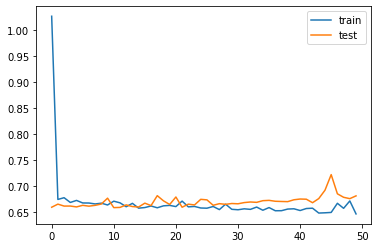

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing accuracies for the 5 players with the most entries in the data-set

In [ ]:
start = time.time()
history_5 = []
acc_5 = []
acc_5_max = []
prob_5 = []
for i in (biggest_5player):
    print('player {}'.format(i))
    print('--------------------------------------------------------------------------')
    prob, history, acc = FFNN(np.array([1,1,7.56,3.6,210,13.7]),player)
    prob_5.append(prob)
    history_5.append(history)
    acc_5.append(acc)
    acc_5_max.append(acc.max())
    print('-------------------------------------------------------------------------')

end = time.time()

Streaming output truncated to the last 5000 lines.
Epoch 8/25
51/51 - 0s - loss: 0.7234 - accuracy: 0.5727 - val_loss: 0.6767 - val_accuracy: 0.6214 - 109ms/epoch - 2ms/step
Epoch 9/25
51/51 - 0s - loss: 0.7211 - accuracy: 0.5832 - val_loss: 0.6921 - val_accuracy: 0.5922 - 104ms/epoch - 2ms/step
Epoch 10/25
51/51 - 0s - loss: 0.7305 - accuracy: 0.5583 - val_loss: 0.6531 - val_accuracy: 0.6505 - 101ms/epoch - 2ms/step
Epoch 11/25
51/51 - 0s - loss: 0.7274 - accuracy: 0.5491 - val_loss: 0.7294 - val_accuracy: 0.5728 - 104ms/epoch - 2ms/step
Epoch 12/25
51/51 - 0s - loss: 0.7508 - accuracy: 0.5701 - val_loss: 0.8334 - val_accuracy: 0.5437 - 105ms/epoch - 2ms/step
Epoch 13/25
51/51 - 0s - loss: 0.7275 - accuracy: 0.5675 - val_loss: 0.6614 - val_accuracy: 0.5728 - 104ms/epoch - 2ms/step
Epoch 14/25
51/51 - 0s - loss: 0.7026 - accuracy: 0.5767 - val_loss: 0.6412 - val_accuracy: 0.6505 - 86ms/epoch - 2ms/step
Epoch 15/25
51/51 - 0s - loss: 0.6924 - accuracy: 0.6160 - val_loss: 0.6443 - val_ac

In [ ]:
for i,player in enumerate(biggest_5player):
    acc = acc_5_max[i] *100
    prob = prob_5[i][0][0]*100
    print('With an accuracy of {:.2f}%, the player {} has a chance of {:.1f}% to score'.format(acc,player,prob))
    print("")
    
print('Time elapsed to get best accuracy result for all 5 players was of {:.2f} min.'.format((end-start)/60))

With an accuracy of 68.93%, the player lebronjames has a chance of 50.0% to score

With an accuracy of 69.90%, the player klaythompson has a chance of 67.4% to score

With an accuracy of 70.87%, the player montaellis has a chance of 61.9% to score

With an accuracy of 70.87%, the player jamesharden has a chance of 65.7% to score

With an accuracy of 68.93%, the player lamarcusaldridge has a chance of 54.5% to score

Time elapsed to get best accuracy result for all 5 players was of 10.14 min.


In [ ]:
nodes1 = np.arange(1,21,3)
nodes2 = np.arange(1,21,3)
for i in range(len(acc_5)):
  #print(acc_5[i])
  best_n1_index = np.where(acc_5 == acc_5[i].max())[0]
  best_n2_index = np.where(acc_5 == acc_5[i].max())[1]
  best_n1 = nodes1[best_n1_index[0]]
  best_n2 = nodes2[best_n2_index[0]]
  print('Player {}'.format(biggest_5player[i]))
  print("The model is optimized with parameters node1 =",best_n1," and node2 =", best_n2) 
  print("")

Player lebronjames
The model is optimized with parameters node1 = 1  and node2 = 7

Player klaythompson
The model is optimized with parameters node1 = 4  and node2 = 13

Player montaellis
The model is optimized with parameters node1 = 7  and node2 = 4

Player jamesharden
The model is optimized with parameters node1 = 7  and node2 = 4

Player lamarcusaldridge
The model is optimized with parameters node1 = 1  and node2 = 7



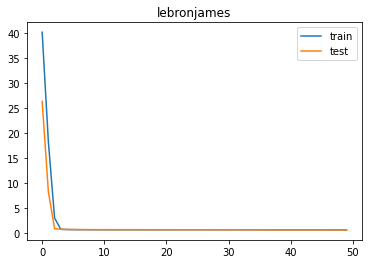

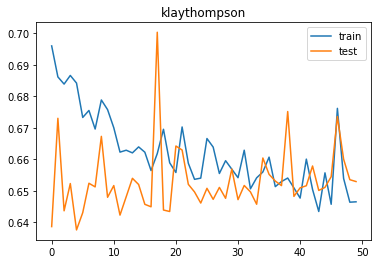

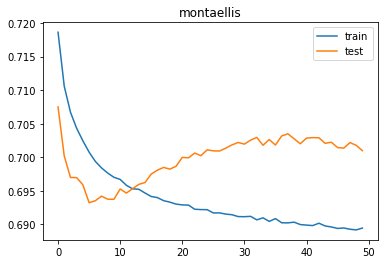

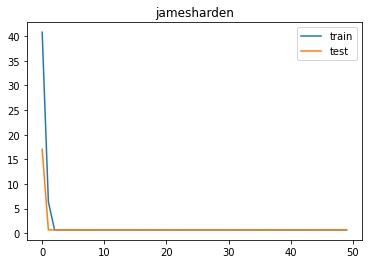

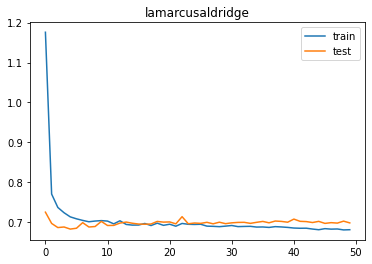

In [ ]:
plt.clf()
for i,player in enumerate(biggest_5player):
    plt.plot(history_5[i].history['loss'], label='train')
    plt.plot(history_5[i].history['val_loss'], label='test')
    plt.title('{}'.format(player))
    plt.legend()
    plt.show()